# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [6]:
# Intstall PyTorch and download data
#!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

^C


In [1]:
from collections import namedtuple

import torchvision.transforms.functional as fn
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [2]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [5]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [6]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [8]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        if scheduler is not None:
            scheduler.step(ave_loss)
            
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    correct = 0 
    total = 0 
    with torch.no_grad():
        for i_step, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            prediction = torch.argmax(model(x) , 1)    
            for i in range(len(prediction)):
                if prediction[i] == y[i]:
                    correct += float(1)
            total += float(len(prediction))
            
            del prediction

    return float(correct/total)



In [9]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)
def plotResults(loss_history, train_history, val_history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(12, 7)

    axs[0].plot(train_history, label="train")
    axs[0].plot(val_history, label="val")
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(loss_history, label = "loss")
    axs[1].grid()
    axs[1].legend()

Average loss: 0.477481, Train accuracy: 0.857216, Val accuracy: 0.839738
Average loss: 0.462075, Train accuracy: 0.861840, Val accuracy: 0.832844
Average loss: 0.447309, Train accuracy: 0.866225, Val accuracy: 0.831889
Average loss: 0.435805, Train accuracy: 0.869809, Val accuracy: 0.855983
Average loss: 0.419259, Train accuracy: 0.875286, Val accuracy: 0.852502


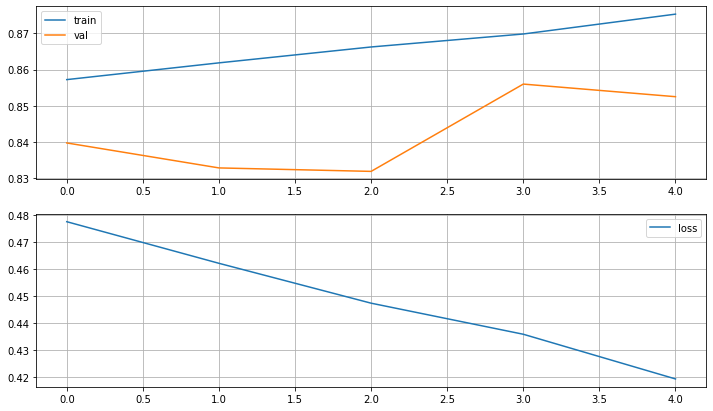

In [10]:
plotResults(loss_history, train_history, val_history)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation = fn.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

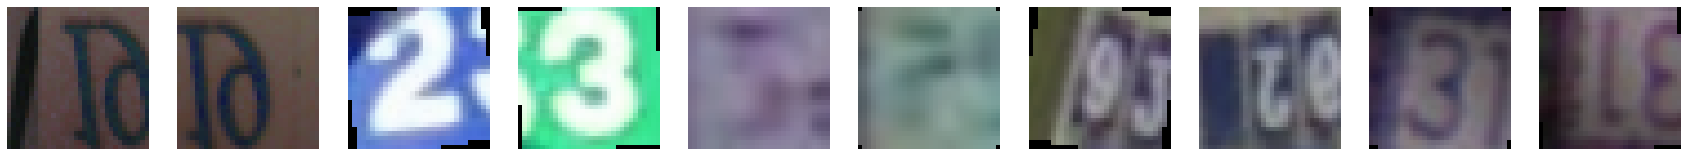

In [62]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation = fn.InterpolationMode.BILINEAR),
])

data_aug_vis = dset.SVHN('./data', transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [13]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomRotation(20, interpolation = fn.InterpolationMode.BILINEAR),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomPerspective(distortion_scale=0.2)                         
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data', transform=tfs)

plt.figure(figsize=(400, 90))
for i, (x, y) in enumerate(data_aug_train):
    if i == 40:
        break
    plt.subplot(4, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [12]:
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.RandomRotation(20, interpolation = fn.InterpolationMode.BILINEAR),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./data', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [108]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.801837, Train accuracy: 0.748285, Val accuracy: 0.822879
Average loss: 0.706555, Train accuracy: 0.779596, Val accuracy: 0.822060
Average loss: 0.667863, Train accuracy: 0.793315, Val accuracy: 0.815917
Average loss: 0.649478, Train accuracy: 0.797717, Val accuracy: 0.838578
Average loss: 0.634740, Train accuracy: 0.804559, Val accuracy: 0.832912


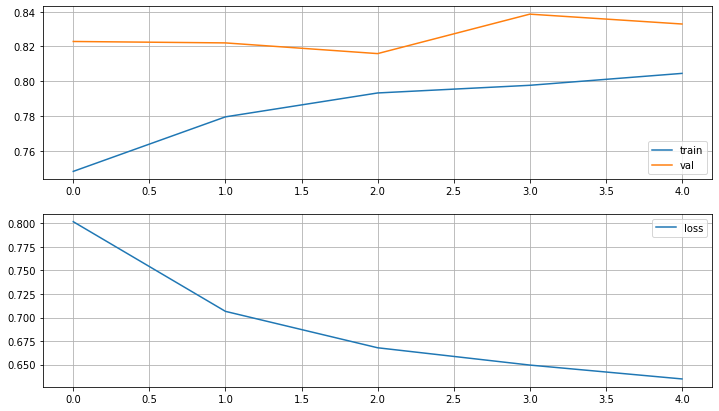

In [109]:
plotResults(loss_history, train_history, val_history)

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [110]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
    
        Flattener(),
        nn.Linear(in_features=16*5*5, out_features=120),
        nn.BatchNorm1d(120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120, out_features=84),
        nn.BatchNorm1d(84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84, out_features=10),
        )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [111]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 0.984539, Train accuracy: 0.683172, Val accuracy: 0.830114
Average loss: 0.664684, Train accuracy: 0.791779, Val accuracy: 0.852843
Average loss: 0.604877, Train accuracy: 0.811009, Val accuracy: 0.863218
Average loss: 0.558617, Train accuracy: 0.824779, Val accuracy: 0.875503
Average loss: 0.529625, Train accuracy: 0.834522, Val accuracy: 0.879803
Average loss: 0.509145, Train accuracy: 0.841194, Val accuracy: 0.875776
Average loss: 0.492727, Train accuracy: 0.846893, Val accuracy: 0.885264
Average loss: 0.477419, Train accuracy: 0.851926, Val accuracy: 0.885127
Average loss: 0.469387, Train accuracy: 0.853155, Val accuracy: 0.885469
Average loss: 0.455382, Train accuracy: 0.858325, Val accuracy: 0.893318


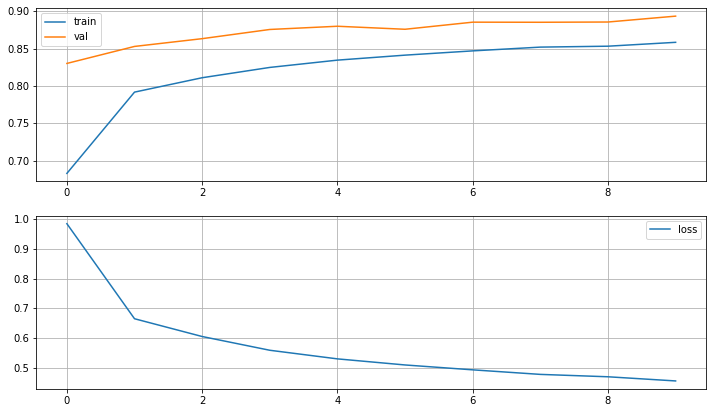

In [112]:
plotResults(loss_history, train_history, val_history)

# Подбор гиперпараметров

In [119]:
def getLenetModel():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
        
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0),
        nn.MaxPool2d(kernel_size=2),
    
        Flattener(),
        nn.Linear(in_features=16*5*5, out_features=120),
        nn.BatchNorm1d(120),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=120, out_features=84),
        nn.BatchNorm1d(84),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=84, out_features=10),
        )
    model.type(torch.cuda.FloatTensor)
    model.to(device)
    return model

In [133]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4]

batch_size = 64
epoch_num = 3
best_accuracy = 0

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

In [134]:
for learnRate in learning_rates:
    for regStr in reg:
        print("Learing rate: ", learnRate, "; RegStr: ", regStr)
        model = getLenetModel()
        
        optimizer = optim.Adam(model.parameters(), lr=learnRate, weight_decay=regStr)
        sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)
        
        loss_history, train_history, val_history = train_model(model, train_aug_loader, val_loader, 
                                                               loss, optimizer,epoch_num, sheduler)
        if val_history[-1] > best_accuracy:
            best_model = model
    
        run_record[Hyperparams(learnRate, regStr)] = RunResult(model, train_history, val_history , val_history[-1])

Learing rate:  1.0 ; RegStr:  0.001
Average loss: 2.517772, Train accuracy: 0.162970, Val accuracy: 0.188656
Average loss: 2.391806, Train accuracy: 0.160786, Val accuracy: 0.146748
Average loss: 2.393753, Train accuracy: 0.162850, Val accuracy: 0.067845
Learing rate:  1.0 ; RegStr:  0.0001
Average loss: 2.415955, Train accuracy: 0.163157, Val accuracy: 0.188656
Average loss: 2.370665, Train accuracy: 0.160513, Val accuracy: 0.077128
Average loss: 2.394968, Train accuracy: 0.165120, Val accuracy: 0.070780
Learing rate:  0.1 ; RegStr:  0.001
Average loss: 2.253469, Train accuracy: 0.187080, Val accuracy: 0.184424
Average loss: 2.248092, Train accuracy: 0.186926, Val accuracy: 0.188656
Average loss: 2.249662, Train accuracy: 0.186431, Val accuracy: 0.188656
Learing rate:  0.1 ; RegStr:  0.0001
Average loss: 2.252515, Train accuracy: 0.185544, Val accuracy: 0.188656
Average loss: 2.247822, Train accuracy: 0.185493, Val accuracy: 0.188656
Average loss: 2.247114, Train accuracy: 0.186721, V

In [135]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.84, best hyperparams: Hyperparams(learning_rate=0.01, reg=0.0001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [159]:
 killerModel = nn.Sequential(
        nn.Conv2d(in_channels=3,  out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),#32x32
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#16x16
        
        nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#8x8
        
        nn.Conv2d(in_channels=128,  out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#4x4
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#2x2
     
        Flattener(),
        nn.Linear(in_features=512*2*2, out_features=1024),
        nn.BatchNorm1d(1024),
        nn.Linear(in_features=1024, out_features=512),
        nn.BatchNorm1d(512),
        nn.Linear(in_features=512, out_features=10),
        )
killerModel.type(torch.cuda.FloatTensor)
killerModel.to(device)
optimizer = optim.Adam(killerModel.parameters(), lr=0.02, weight_decay=0.0001)
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer , factor = 0.5 , patience= 2 , verbose= True)

In [160]:
loss_history, train_history, val_history = train_model(killerModel, train_aug_loader, val_loader, 
                                                               loss, optimizer, 15, sheduler)

Average loss: 2.320267, Train accuracy: 0.199263, Val accuracy: 0.232885
Average loss: 1.042763, Train accuracy: 0.651793, Val accuracy: 0.825336
Average loss: 0.659724, Train accuracy: 0.795004, Val accuracy: 0.801993
Average loss: 0.623894, Train accuracy: 0.808125, Val accuracy: 0.838919
Average loss: 0.600913, Train accuracy: 0.814780, Val accuracy: 0.844311
Average loss: 0.587869, Train accuracy: 0.820035, Val accuracy: 0.863832
Average loss: 0.577792, Train accuracy: 0.822680, Val accuracy: 0.880076
Average loss: 0.566885, Train accuracy: 0.827048, Val accuracy: 0.854959
Average loss: 0.560185, Train accuracy: 0.828977, Val accuracy: 0.843219
Average loss: 0.561779, Train accuracy: 0.830103, Val accuracy: 0.842127
Average loss: 0.549126, Train accuracy: 0.833276, Val accuracy: 0.855778
Average loss: 0.541984, Train accuracy: 0.835751, Val accuracy: 0.873251
Average loss: 0.547783, Train accuracy: 0.833208, Val accuracy: 0.868610
Average loss: 0.535660, Train accuracy: 0.837252, V

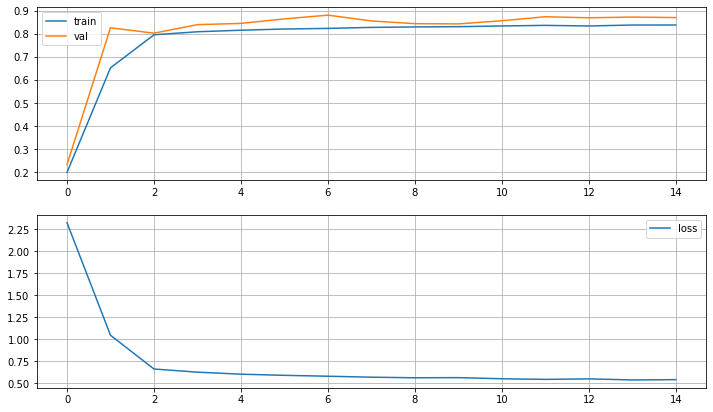

In [161]:
plotResults(loss_history, train_history, val_history)

In [14]:
killerModel = nn.Sequential(
        nn.Conv2d(in_channels=3,  out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),#32x32
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(64),
        nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#16x16
        
        nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        #nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#8x8
        
        nn.Conv2d(in_channels=128,  out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        #nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#4x4
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
        nn.BatchNorm2d(512),
        #nn.Dropout(0.2),
        nn.MaxPool2d(kernel_size=2),#2x2
     
        Flattener(),
        nn.Linear(in_features=512*2*2, out_features=1024),
        nn.BatchNorm1d(1024),
        nn.Linear(in_features=1024, out_features=10),
        )
killerModel.type(torch.cuda.FloatTensor)
killerModel.to(device)
optimizer = optim.Adam(killerModel.parameters(), lr=0.02, weight_decay=0.00001)
sheduler = optim.lr_scheduler.StepLR(optimizer , step_size=4, gamma=0.5)

c:\users\neo\appdata\local\programs\python\python38\lib\site-packages\torch\optim\lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Average loss: 0.436949, Train accuracy: 0.864997, Val accuracy: 0.899597
Average loss: 0.400682, Train accuracy: 0.879535, Val accuracy: 0.900689
Average loss: 0.372574, Train accuracy: 0.888168, Val accuracy: 0.890929
Average loss: 0.360569, Train accuracy: 0.892673, Val accuracy: 0.898164
Average loss: 0.343529, Train accuracy: 0.897860, Val accuracy: 0.922121
Average loss: 0.331659, Train accuracy: 0.902109, Val accuracy: 0.923623
Average loss: 0.346201, Train accuracy: 0.898986, Val accuracy: 0.902327
Average loss: 0.345948, Train accuracy: 0.897144, Val accuracy: 0.922736
Average loss: 0.315296, Train accuracy: 0.907399, Val accuracy: 0.927172
Average loss: 0.328671, Train accuracy: 0.902774, Val accuracy: 0.924237
Average loss: 0.492237, Train accuracy: 0.863871, Val accuracy: 0.906150
Average loss: 0.320370, Train accuracy: 0.903815, Val accuracy: 0.922121
Average loss: 0.321946, Train accuracy: 0.905163, Val accuracy: 0.908402
Average loss: 0.334908, Train accuracy: 0.901631, V

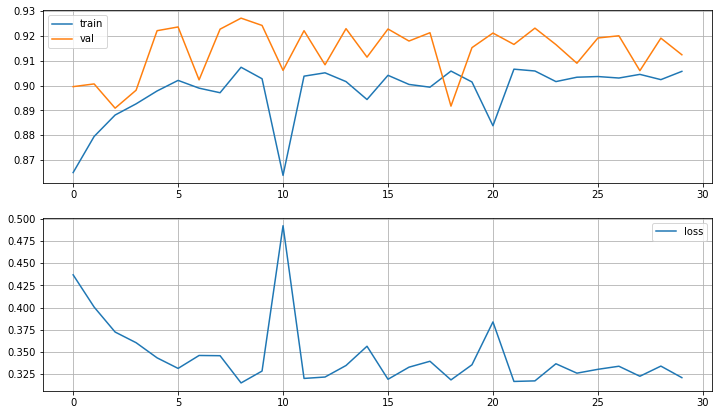

In [16]:
loss_history, train_history, val_history = train_model(killerModel, train_aug_loader, val_loader, 
                                                               loss, optimizer, 30, sheduler)
plotResults(loss_history, train_history, val_history)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [17]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(killerModel, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9197141979102643
